In [1]:
from __future__ import annotations
import torch
from torch import Tensor
import random
import math
from typing import List, Tuple, Union, Iterable, Callable, Optional
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

## Config

In [2]:
State = Tensor # vehicle, vuln, feature
StateBatch = Tensor
DefenderAction = Tensor # vehicles
DefenderActionBatch = Tensor
DefenderActionBatchBatch = Tensor
AttackerAction = Tensor # vehicles
AttackerActionBatch = Tensor
Reward = Tensor
RewardBatch = Tensor
Terminal = Tensor
TerminalBatch = Tensor

MAX_VEHICLES                        = 10     #@param {type:"integer"}
MAX_VULNS                           = 3      #@param {type:"integer"}
MAX_ATTACK                          = 2      #@param {type:"integer"}

ACTION_K                            = 5      #@param {type:"integer"}

BATCH_SIZE                          = 1000    #@param {type:"integer"}

MEMORY_SIZE                         = 1000000  #@param {type:"integer"}
MEMORY_WARMUP_STEPS                 = MEMORY_SIZE // BATCH_SIZE     #@param {type:"integer"} # scaled by batch size

TRAIN_STEPS                         = 500     #@param {type:"integer"}
EXPLORATION_STEPS_PER_TRAIN_STEP    = 1      #@param {type:"integer"} # scaled by batch size

LEARNING_RATE                       = 0.001  #@param {type:"number"}
LEARNING_RATE_GAMMA                 = 0.9    #@param {type:"number"}
LEARNING_RATE_GAMMA_FREQUENCY       = 500    #@param {type:"integer"}

REWARD_GAMMA                        = 0.99   #@param {type:"number"}

EPSILON_DECAY_STEPS                 = 10000  #@param {type:"integer"}
EPSILON_THETA                       = 1.0    #@param {type:"number"}
EPSILON_MU                          = 0.0    #@param {type:"number"}
EPSILON_SIGMA                       = 3      #@param {type:"number"}

SOFT_UPDATE_TAU                     = 0.001  #@param {type:"number"}

EVAL_STEPS                          = 100    #@param {type:"integer"}

DEVICE = torch.cuda.is_available() and torch.device('cuda') or torch.device('cpu')

## Definitions

### States

#### get random starting state batch

In [3]:
def get_random_starting_state_batch(num_batches: int) -> StateBatch:
    prob_dist = torch.distributions.Normal(
        loc=torch.as_tensor(0.5, dtype=torch.float32),
        scale=torch.as_tensor(0.25, dtype=torch.float32),
    )
    sev_dist = torch.distributions.Normal(
        loc=torch.as_tensor(2, dtype=torch.float32),
        scale=torch.as_tensor(1, dtype=torch.float32),
    )
    states = torch.zeros((num_batches, MAX_VEHICLES, MAX_VULNS, 4), dtype=torch.float32)
    states[:,:,:,0] = prob_dist.sample(torch.Size((num_batches, MAX_VEHICLES, MAX_VULNS))).clamp(0,1)
    states[:,:,:,1] = sev_dist.sample(torch.Size((num_batches, MAX_VEHICLES, MAX_VULNS))).round().clamp(1,5)
    novulns = torch.rand(torch.Size((num_batches, MAX_VEHICLES, MAX_VULNS))) > 0.5
    states[novulns, :] = 0

    return states # prob, sev, compromised_flag, member_flag

#### get random starting state

In [4]:
def get_random_starting_state() -> State:
    return get_random_starting_state_batch(1)[0]

#### get empty state

In [5]:
def get_empty_state() -> State:
    return torch.zeros((MAX_VEHICLES, MAX_VULNS, 4), dtype=torch.float32)

#### batch states

In [6]:
def batch_states(states: Union[Tuple[State, ...], List[State]]) -> StateBatch:
    return torch.stack(states)

### Actions

#### get action space

In [7]:
# https://stackoverflow.com/a/58869630/11141271
def get_action_space() -> DefenderActionBatch:
    return torch.arange(MAX_VEHICLES).unsqueeze(1)
    # return ((torch.arange(2**MAX_VEHICLES).unsqueeze(1) >> torch.arange(MAX_VEHICLES-1, -1, -1)) & 1).float()

In [8]:
assert ACTION_K <= get_action_space().shape[0]

#### get attacker actions

In [9]:
def get_attacker_actions(states: StateBatch) -> AttackerActionBatch:
    priority = (states[:,:,:,0] * states[:,:,:,1] * (1-states[:,:,:,2])).sum(dim=-1)
    # find indices of vehicles to attack
    attack = priority.topk(MAX_ATTACK).indices
    # return mask of vehicles to attack
    return torch.zeros((states.shape[0], MAX_VEHICLES), dtype=torch.float32).to(states.device).scatter_(1, attack, 1)

#### apply attacker actions

In [10]:
def apply_attacker_actions(states: StateBatch, actions: AttackerActionBatch) -> StateBatch:
    assert states.shape[0] == actions.shape[0]
    assert states.device == actions.device


    next_states = states.clone()

    attack_mask = get_attacker_actions(states).bool()
    attack = next_states[attack_mask]

    probs = torch.rand(attack.shape[:-1], dtype=torch.float32, device=states.device)
    success_mask = (probs > 1-attack[:,:,0])

    # we need to copy some data since advanced slicing creates copies
    success = attack[success_mask]
    success[:,2] = 1
    attack[success_mask] = success
    next_states[attack_mask] = attack
    return next_states

#### get random defender actions

In [11]:
def get_random_defender_actions(states: StateBatch) -> DefenderActionBatch:
    # pick num vehicles in platoon
    return torch.rand((states.shape[0],1), dtype=torch.float32) * MAX_VEHICLES

    # return (torch.rand((states.shape[0], MAX_VEHICLES), dtype=torch.float32, device=states.device) > 0.5).float()

#### get exploring defender actions

In [12]:
def get_exploring_defender_actions(states: StateBatch) -> DefenderActionBatch:
    assert states.shape[0] >= MAX_VEHICLES * 2 + 1 # we want to give diagonal and random actions a chance

    return torch.cat((
        torch.arange(0,MAX_VEHICLES+1, device=states.device, dtype=torch.float32).unsqueeze(1),
        get_random_defender_actions(states[MAX_VEHICLES+1:]),
    ))

    # zero = torch.zeros((1,MAX_VEHICLES))
    # diag = torch.eye(MAX_VEHICLES, dtype=torch.float32, device=states.device)
    # rand = get_random_defender_actions(states[MAX_VEHICLES+1:])
    # return torch.cat((zero, diag, rand))

In [13]:
# todo: nearest neighbour for actions to find N nearest neighbours
# just subtract the action from the action space and take the argmin

#### apply defender actions

In [74]:
def apply_defender_actions(states: StateBatch, actions: DefenderActionBatch) -> StateBatch:
    assert states.shape[0] == actions.shape[0]
    assert states.device == actions.device

    # create a copy so we don't modify the original
    states = states.clone()

    # set the membership flag to 1 for each vuln in each vehicle that is chosen
    states[:,:,:,3] = 0

    for i in range(states.shape[0]):
        platoon_size = actions[i][0].clamp(0, MAX_VEHICLES)
        members = random.sample(range(MAX_VEHICLES), int(platoon_size))
        states[i,members,:,3] = 1

    # for i in range(states.shape[0]):
    #     states[i,actions[i,:]==1,:,3] = 1

    return states

#### nearest k actions

In [63]:
def get_nearest_k_actions(proto_actions: DefenderActionBatch, k: int) -> DefenderActionBatchBatch:
    # get all possible actions
    space = get_action_space().to(proto_actions.device)
    # copy the action set for each proto action
    space2 = space.unsqueeze(0).repeat((proto_actions.shape[0], 1, 1))
    # duplicate the proto actions for each action in the space
    proto_actions = proto_actions.unsqueeze(1).repeat((1, space.shape[0], 1))
    # find the indices of nearest k actions for each proto action
    nearest = (space2 - proto_actions).abs().sum(dim=2).topk(largest=False, k=k, dim=1).indices
    # return the actions themselves using the indices
    return space[nearest]

#### Epsilon noise

##### OrnsteinUhlenbeck

In [16]:
# from original deepRL author code
# Based on http://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab
class OrnsteinUhlenbeckProcess():
    def __init__(self, theta, mu=0., sigma=1., dt=1e-2, x0=None, size=1, sigma_min=None, n_steps_annealing=1000):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.n_steps = 0
        
        if sigma_min is not None:
            self.m = -float(sigma - sigma_min) / float(n_steps_annealing)
            self.c = sigma
            self.sigma_min = sigma_min
        else:
            self.m = 0.
            self.c = sigma
            self.sigma_min = sigma

        self.dt = dt
        self.x0 = x0
        self.size = size
        self.normal = torch.distributions.Normal(torch.as_tensor(0, dtype=torch.float32), torch.as_tensor(1, dtype=torch.float32))
        self.reset_states()

    @property
    def current_sigma(self):
        sigma = max(self.sigma_min, self.m * float(self.n_steps) + self.c)
        return sigma

    def sample(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.current_sigma * torch.sqrt(torch.as_tensor(self.dt, dtype=torch.float32)) * self.normal.sample((self.size,))  # type: ignore
        self.x_prev = x
        self.n_steps += 1
        return x

    def reset_states(self):
        self.x_prev = self.x0 if self.x0 is not None else torch.zeros(self.size)

##### Noise preview

c:\Users\TeamD\.conda\envs\subgame\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
c:\Users\TeamD\.conda\envs\subgame\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


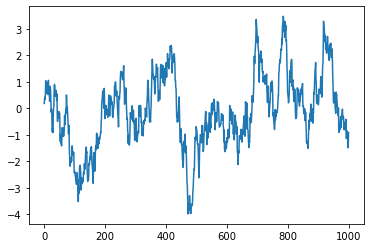

In [17]:
a = OrnsteinUhlenbeckProcess(
    size=1,
    theta=EPSILON_SIGMA,
    mu=EPSILON_MU,
    sigma=EPSILON_SIGMA,
)
b = [a.sample() for _ in range(1000)]
plt.plot(b)
del a
del b

##### apply epsilon noise

In [53]:
epsilon = 1.0
epsilon_decay = epsilon / EPSILON_DECAY_STEPS
epsilon_noise = OrnsteinUhlenbeckProcess(
    # size=MAX_VEHICLES,
    size=1,
    theta=EPSILON_SIGMA,
    mu=EPSILON_MU,
    sigma=EPSILON_SIGMA,
)
def apply_epsilon_noise(actions: DefenderActionBatch) -> None:
    actions += epsilon * epsilon_noise.sample().to(actions.device)

In [54]:
z = torch.zeros((2,2,10))
apply_epsilon_noise(z)
print(z)

tensor([[[0.7626, 0.7626, 0.7626, 0.7626, 0.7626, 0.7626, 0.7626, 0.7626,
          0.7626, 0.7626],
         [0.7626, 0.7626, 0.7626, 0.7626, 0.7626, 0.7626, 0.7626, 0.7626,
          0.7626, 0.7626]],

        [[0.7626, 0.7626, 0.7626, 0.7626, 0.7626, 0.7626, 0.7626, 0.7626,
          0.7626, 0.7626],
         [0.7626, 0.7626, 0.7626, 0.7626, 0.7626, 0.7626, 0.7626, 0.7626,
          0.7626, 0.7626]]])


### Rewards

#### get defender utilities

In [20]:
def get_defender_utilities(states: StateBatch) -> RewardBatch:
    # identify which platoons contain compromised vehicles
    compromise_free_platoons = (states[:,:,:,2] * states[:,:,:,3]).sum(dim=[-1,-2]) == 0
    # identify size of each platoon
    members = states[:,:,:,3].max(dim=-1).values.sum(dim=-1)
    # return 0 if platoon is compromised, size of platoon otherwise
    return members * compromise_free_platoons.float()

### Modelling

In [21]:
import torch.nn as nn
import torch.nn.functional as F

#### Actor

In [46]:
class DefenderActor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.LazyConv2d(out_channels=5, kernel_size=2, stride=1)
        self.fc1 = nn.LazyLinear(256)
        self.fc2 = nn.LazyLinear(128)
        # self.fc3 = nn.LazyLinear(MAX_VEHICLES)
        self.fc3 = nn.LazyLinear(1)

    def forward(self, x: StateBatch) -> DefenderActionBatch:
        x = torch.hstack((
            F.gelu(self.conv1(x)).flatten(start_dim=1),
            x.flatten(start_dim=1), # skip connection after conv
        ))
        x = F.gelu(self.fc1(x))
        x = F.gelu(self.fc2(x))
        # x = torch.tanh(self.fc3(x))
        x = F.relu(self.fc3(x))
        return x

#### Critic

In [56]:
class DefenderCritic(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # self.conv1 = nn.LazyConv2d(out_channels=5, kernel_size=2, stride=1)
        self.fc1 = nn.LazyLinear(256)
        self.fc2 = nn.LazyLinear(128)
        self.fc3 = nn.LazyLinear(1)
    def forward(self, x1: StateBatch, x2: DefenderActionBatch) -> Reward:
        x = torch.hstack((
            # F.gelu(self.conv1(x1)).flatten(start_dim=1),
            x1.flatten(start_dim=1), # skip connection after conv
            x2,
        ))
        x = F.gelu(self.fc1(x))
        x = F.gelu(self.fc2(x))
        x = self.fc3(x)
        return x

#### get defender actions

In [72]:
def get_defender_actions(
    states: StateBatch,
    actor: DefenderActor,
    critic: DefenderCritic,
    proto_mutator: Optional[Callable[[DefenderActionBatch],None]],
) -> DefenderActionBatch:
    proto_actions = actor(states)
    if proto_mutator is not None:
        proto_mutator(proto_actions)
    nearest_actions = get_nearest_k_actions(proto_actions, ACTION_K)
    states_ = states.unsqueeze(1).repeat(1,ACTION_K,1,1,1).reshape(-1,MAX_VEHICLES,MAX_VULNS,4)
    # actions_ = nearest_actions.reshape(-1, MAX_VEHICLES)
    actions_ = nearest_actions.reshape(-1, 1)
    q_values = critic(states_, actions_).reshape(states.shape[0], ACTION_K)
    return nearest_actions[torch.arange(states.shape[0]), q_values.argmax(dim=1)]

#### Replay memory

In [25]:
from collections import deque
from dataclasses import dataclass

@dataclass
class Transition:
    state: State
    action: DefenderAction
    reward: Reward
    next_state: State
    terminal: Terminal

    def to(self, device: torch.device) -> 'Transition':
        return Transition(
            state=self.state.to(device),
            action=self.action.to(device),
            reward=self.reward.to(device),
            next_state=self.next_state.to(device),
            terminal=self.terminal.to(device),
        )

@dataclass
class TransitionBatch:
    states: StateBatch
    actions: DefenderActionBatch
    rewards: RewardBatch
    next_states: StateBatch
    terminals: TerminalBatch

    
    def to(self, device: torch.device) -> 'TransitionBatch':
        return TransitionBatch(
            states=self.states.to(device),
            actions=self.actions.to(device),
            rewards=self.rewards.to(device),
            next_states=self.next_states.to(device),
            terminals=self.terminals.to(device),
        )

In [26]:
def sample_memory(memory: deque, batch_size: int) -> TransitionBatch:
    samples = random.sample(memory, batch_size)
    return TransitionBatch(
        states=torch.stack([s.state for s in samples]),
        actions=torch.stack([s.action for s in samples]),
        rewards=torch.stack([s.reward for s in samples]),
        next_states=torch.stack([s.next_state for s in samples]),
        terminals=torch.stack([s.terminal for s in samples]),
    )

### Learning and exploration

In [28]:
# from https://github.com/ghliu/pytorch-ddpg/blob/master/util.py#L26

def soft_update(target, source, tau):
        for target_param, param in zip(target.parameters(), source.parameters()):
            ## shouldn't be necessary since we use target networks to calculate loss
            # if isinstance(target_param, torch.nn.parameter.UninitializedParameter):
            #     # target model uninitialize, hard update
            #     target_param.data.copy_(param.data)
            # else:
            target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

def hard_update(target, source):
    for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)

## Training

### Init

In [29]:
# memory: deque[Transition] = deque(maxlen=MEMORY_SIZE) # colab uses old python version that doesn't support this :P
memory = deque(maxlen=MEMORY_SIZE)

In [57]:
actor = DefenderActor().to(DEVICE)
actor_target = DefenderActor().to(DEVICE)
critic = DefenderCritic().to(DEVICE)
critic_target = DefenderCritic().to(DEVICE)

In [58]:
# ensure weights are initialized
states = get_random_starting_state_batch(1).to(DEVICE)
critic(states, actor(states))
critic_target(states, actor_target(states))

# hard update weights
hard_update(actor_target, actor)
hard_update(critic_target, critic)

In [59]:
actor_optimizer = torch.optim.Adam(actor.parameters(), lr=LEARNING_RATE)
actor_scheduler = torch.optim.lr_scheduler.StepLR(
    actor_optimizer,
    step_size=LEARNING_RATE_GAMMA_FREQUENCY,
    gamma=LEARNING_RATE_GAMMA,
)
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=LEARNING_RATE)
critic_scheduler = torch.optim.lr_scheduler.StepLR(
    critic_optimizer,
    step_size=LEARNING_RATE_GAMMA_FREQUENCY,
    gamma=LEARNING_RATE_GAMMA,
)

In [50]:
criterion = nn.MSELoss()

### Warmup

#### Random games

In [34]:
states = get_random_starting_state_batch(BATCH_SIZE)

# perform random exploration for one set of state sequences
for _ in tqdm(range(MEMORY_WARMUP_STEPS // 2)):
    assert len(memory) < MEMORY_SIZE
    # random exploration
    defender_actions = get_exploring_defender_actions(states)
    next_states = apply_defender_actions(states, defender_actions)
    attacker_actions = get_attacker_actions(next_states)
    next_states = apply_attacker_actions(next_states, attacker_actions)
    rewards = get_defender_utilities(next_states)
    terminals = rewards == 0

    # track next states as empty if terminal
    next_states[terminals] = get_empty_state()

    # save each transition in the batch to memory
    for i in range(BATCH_SIZE):
        memory.append(Transition(
            state=states[i],
            action=defender_actions[i],
            reward=rewards[i],
            next_state=next_states[i],
            terminal=torch.as_tensor(rewards[i] == 0),
        ))

    # reset environment for terminal states
    states = next_states.clone()
    states[terminals] = get_random_starting_state_batch(int(terminals.sum()))

del states

  0%|          | 0/500 [00:00<?, ?it/s]

#### Alternate paths

In [35]:
# using random states from the memory, see what would happen if we took different actions at those states
for _ in tqdm(range(MEMORY_WARMUP_STEPS // 2)):
    assert len(memory) < MEMORY_SIZE

    states = sample_memory(memory, BATCH_SIZE).states

    # random exploration
    defender_actions = get_exploring_defender_actions(states)
    next_states = apply_defender_actions(states, defender_actions)
    attacker_actions = get_attacker_actions(next_states)
    next_states = apply_attacker_actions(next_states, attacker_actions)
    rewards = get_defender_utilities(next_states)
    terminals = rewards == 0

    # track next states as empty if terminal
    next_states[terminals] = get_empty_state()

    # save each transition in the batch to memory
    for i in range(BATCH_SIZE):
        memory.append(Transition(
            state=states[i],
            action=defender_actions[i],
            reward=rewards[i],
            next_state=next_states[i],
            terminal=torch.as_tensor(rewards[i] == 0),
        ))

    # reset environment for terminal states
    states = next_states.clone()
    states[terminals] = get_random_starting_state_batch(int(terminals.sum()))

  0%|          | 0/500 [00:00<?, ?it/s]

### Preflight checks

In [36]:
print(len(memory)/MEMORY_SIZE)

1.0


(array([718.,  84.,  70.,  40.,  37.,  21.,  15.,   9.,   3.,   3.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
       dtype=float32),
 <BarContainer object of 10 artists>)

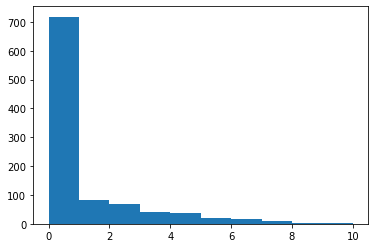

In [37]:
plt.hist(sample_memory(memory, 1000).rewards.numpy())

In [38]:
a = sample_memory(memory, 1000).rewards.count_nonzero()
print(a, a/1000)

tensor(269) tensor(0.2690)


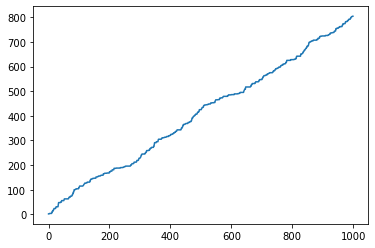

In [39]:
plt.plot(sample_memory(memory, 1000).rewards.cumsum(0).numpy())

### Train loop

In [75]:
critic_loss_history = []
actor_loss_history = []
actor_learning_rate_history = []
critic_learning_rate_history = []
epsilon_history = []

In [76]:
digits = math.ceil(math.log10(TRAIN_STEPS))
states = get_random_starting_state_batch(BATCH_SIZE).to(DEVICE)
with tqdm(total=TRAIN_STEPS) as pbar:
    for i in range(TRAIN_STEPS):
        # EXPLORE
        for j in range(EXPLORATION_STEPS_PER_TRAIN_STEP):
            defender_actions = get_defender_actions(states, actor, critic, apply_epsilon_noise)
            epsilon_history.append(epsilon)
            epsilon = max(0.0, epsilon - epsilon_decay)
            next_states = apply_defender_actions(states, defender_actions)
            attacker_actions = get_attacker_actions(next_states)
            next_states = apply_attacker_actions(next_states, attacker_actions)
            rewards = get_defender_utilities(next_states)
            terminals = rewards == 0

            # track next states as empty if terminal
            next_states[terminals] = get_empty_state().to(DEVICE)
            
            # save each transition in the batch to memory
            for i in range(BATCH_SIZE):
                memory.append(Transition(
                    state=states[i],
                    action=defender_actions[i],
                    reward=rewards[i],
                    next_state=next_states[i],
                    terminal=torch.as_tensor(rewards[i] == 0, dtype=torch.bool),
                ).to(torch.device("cpu")))

            # reset environment for terminal states
            states = next_states.clone()
            num_terminal = int(terminals.sum() > 0)
            if num_terminal > 0:
                states[terminals] = get_random_starting_state_batch(num_terminal).to(DEVICE)

        # OPTIMIZE
        batch = sample_memory(memory, BATCH_SIZE).to(DEVICE)

        with torch.no_grad():
            q_next: Tensor = critic_target(
                batch.next_states,
                actor_target(batch.next_states),
            )
        q_next.requires_grad_()
        q_target = q_next * REWARD_GAMMA * (1-batch.terminals.float().unsqueeze(1)) + batch.rewards.unsqueeze(1)

        critic.zero_grad()
        q_pred = critic(batch.states, batch.actions)
        critic_loss = criterion(q_pred, q_target)
        critic_loss.backward()
        critic_optimizer.step()
        critic_learning_rate_history.append(critic_scheduler.get_last_lr())
        critic_scheduler.step()
        
        critic_loss_history.append(critic_loss.item())


        actor.zero_grad()
        actor_loss = -critic(batch.states, actor(batch.states)).mean()
        actor_loss.backward()
        actor_optimizer.step()
        actor_learning_rate_history.append(actor_scheduler.get_last_lr())
        actor_scheduler.step()
        actor_loss_history.append(actor_loss.item())

        soft_update(actor_target, actor, SOFT_UPDATE_TAU)
        soft_update(critic_target, critic, SOFT_UPDATE_TAU)

        pbar.set_description(f"critic: {critic_loss.item():.3f}, actor: {actor_loss.item():.3f}")

        pbar.update()



  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Training metrics

#### Critic loss

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


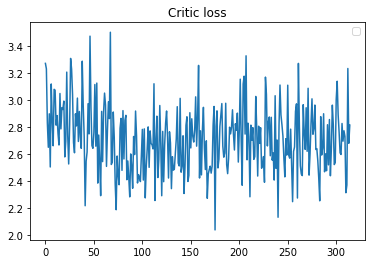

In [77]:
plt.plot(critic_loss_history)
plt.title("Critic loss")
plt.legend()

#### Actor loss

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


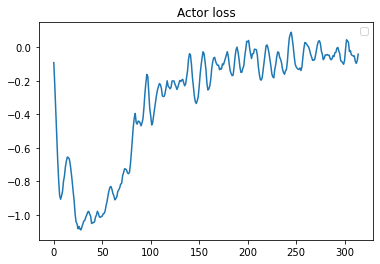

In [78]:
plt.plot(actor_loss_history)
plt.title("Actor loss")
plt.legend()

#### Actor learning rate

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


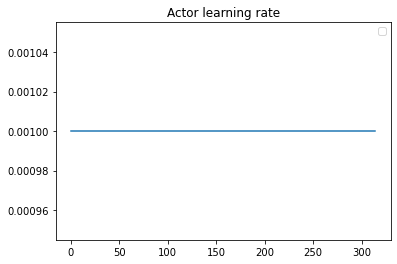

In [79]:
plt.plot(actor_learning_rate_history)
plt.title("Actor learning rate")
plt.legend()

#### Critic learning rate

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


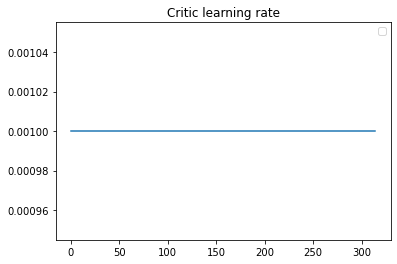

In [80]:
plt.plot(critic_learning_rate_history)
plt.title("Critic learning rate")
plt.legend()

#### Epsilon

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


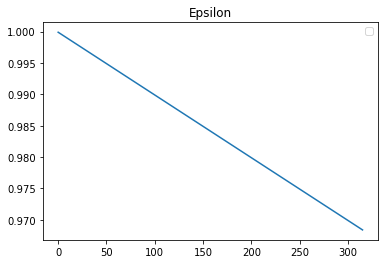

In [81]:
plt.plot(epsilon_history)
plt.title("Epsilon")
plt.legend()

## Eval

In [82]:
eval_rewards = []
eval_streaks = []
eval_actions = []
random_rewards = []

### Eval steps

In [83]:
states = get_random_starting_state_batch(BATCH_SIZE).to(DEVICE)
streaks = torch.zeros((BATCH_SIZE,))

for _ in tqdm(range(EVAL_STEPS)):
    # random agent evaluted just for reference
    defender_actions = get_random_defender_actions(states)
    next_states = apply_defender_actions(states, defender_actions)
    attacker_actions = get_attacker_actions(next_states)
    next_states = apply_attacker_actions(next_states, attacker_actions)
    rewards = get_defender_utilities(next_states)
    random_rewards.extend(rewards.tolist())

    # learning agent determines next state
    defender_actions = get_defender_actions(states, actor, critic, None)
    next_states = apply_defender_actions(states, defender_actions)
    attacker_actions = get_attacker_actions(next_states)
    next_states = apply_attacker_actions(next_states, attacker_actions)
    rewards = get_defender_utilities(next_states)
    eval_rewards.extend(rewards.tolist())
    eval_actions.extend(defender_actions.tolist())
    
    terminals = rewards == 0
    eval_streaks += streaks[terminals].tolist()
    streaks[terminals] = 0
    streaks[~terminals] += 1

    # track next states as empty if terminal
    next_states[terminals] = get_empty_state().to(DEVICE)

    # reset environment for terminal states
    states = next_states.clone()
    states[terminals] = get_random_starting_state_batch(int(terminals.sum())).to(DEVICE)

  0%|          | 0/100 [00:00<?, ?it/s]

### Streaks

C:\Users\TeamD\AppData\Local\Temp/ipykernel_1252/738803523.py:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.hist(eval_streaks, bins=torch.range(min(eval_streaks)-0.5,max(eval_streaks)+0.5).tolist())


Text(0.5, 1.0, 'Streaks')

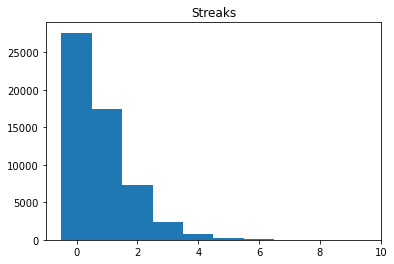

In [84]:
plt.hist(eval_streaks, bins=torch.range(min(eval_streaks)-0.5,max(eval_streaks)+0.5).tolist())
plt.title("Streaks")

### Rewards

In [85]:
print("eval", torch.mean(torch.tensor(eval_rewards)), torch.mean(torch.tensor(eval_streaks)))
print("rand", torch.mean(torch.tensor(random_rewards)))

eval tensor(1.2538) tensor(0.7823)
rand tensor(0.7165)


C:\Users\TeamD\AppData\Local\Temp/ipykernel_1252/13135481.py:6: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.hist(eval_rewards, bins=torch.range(min(eval_rewards)-0.5,max(eval_rewards)+0.5).tolist())


Text(0.5, 1.0, 'Eval rewards')

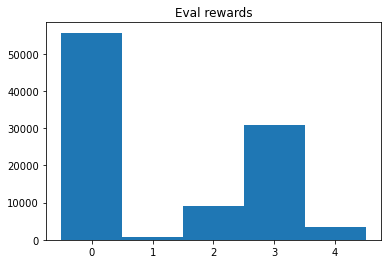

In [86]:
# import ipywidgets as widgets
# @widgets.interact(i=(0, BATCH_SIZE-1))
# def asd(i=0):
#     plt.plot(torch.vstack(eval_rewards)[:,i].cpu().numpy())

plt.hist(eval_rewards, bins=torch.range(min(eval_rewards)-0.5,max(eval_rewards)+0.5).tolist())
plt.title("Eval rewards")

C:\Users\TeamD\AppData\Local\Temp/ipykernel_1252/3988268182.py:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.hist(random_rewards, bins=torch.range(min(random_rewards)-0.5,max(random_rewards)+0.5).tolist())


Text(0.5, 1.0, 'Random rewards')

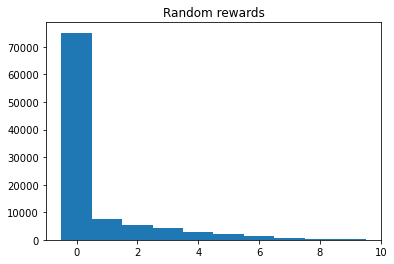

In [87]:
plt.hist(random_rewards, bins=torch.range(min(random_rewards)-0.5,max(random_rewards)+0.5).tolist())
plt.title("Random rewards")

### Actions

In [89]:
import ipywidgets as widgets
@widgets.interact(i=(0, len(eval_actions)-1), window_size=(1, len(eval_actions)-1))
def preview_actions(i=0, window_size=50):
    plt.imshow(eval_actions[i:i+window_size], aspect="auto")

interactive(children=(IntSlider(value=0, description='i', max=99999), IntSlider(value=50, description='window_…